In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git
!pip3 install cma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-s64n50vq
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-s64n50vq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-6fszbkzf/pydoe_0ccab71f5ae44e41aeac409244f3ebf7
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-6fszbkzf/pydoe_0ccab71f5ae44e41aeac409244f3ebf7
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 316 kB 47.2 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=edf668c15ec68c82684ade01c82f842453a9f9468c2c1bbc6228dd8c34b6b385
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cma

from bayes_optim import BO
from bayes_optim.search_space import RealSpace
from bayes_optim.surrogate import GaussianProcess, trend

from pyDOE import lhs

from scipy.stats.qmc import Sobol, Halton

from benchmark.bbobbenchmarks import F12

from tqdm.notebook import tqdm, trange

import pandas as pd

np.random.seed(1111)

dim = 2
lb, ub = -5, 5

mean = trend.constant_trend(dim, beta=None)
thetaL = 1e-10 * (ub - lb) * np.ones(dim)
thetaU = 10 * (ub - lb) * np.ones(dim)
theta0 = np.random.rand(dim) * (thetaU - thetaL) + thetaL

max_FEs = 2**6
verbose = False

space = RealSpace([lb, ub], random_state=np.random.randint(1, 10000)) * dim
n_samples = 30000
samples = space.sample(n_samples)

obj_func = F12(1)

doe_budget = 0.1
doe_size = int(doe_budget * max_FEs)
values = obj_func(samples)

n_runs = 100

In [6]:
opt_color, found_color, initial_color = "green", "red", "blue"

def plot(points, colors, ax=plt, outline=False, marker='o', marker_size=30):
    transposed = np.transpose(points)
    if outline:
        ax.scatter(transposed[0], transposed[1], color="none", edgecolor=colors, marker=marker, s=marker_size)
    else:
        ax.scatter(transposed[0], transposed[1], c=colors, marker=marker, s=marker_size)


# plot DoE, optimum, found by the BO, and global optimum on the surface of the function
def plot_result(func, samples, values, result, ax):
  plot(samples, values, ax=ax, outline=False)
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^')
  ax.set_title(f'{result.get("description", "regret")}: {result["regret"]}', size=6)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s')


# plot DoE, all points used by the BO during training, global optimum, found optimum
def plot_ei_performance(func, samples, values, bo, result, marker_size=30, ax=None):
  if ax is None:
    ax = plt.gca()
  plot(samples, values, ax=ax, outline=False) # plot surface
  if result["doe"] is not None:
    plot(result["doe"], ["blue"] * result["doe"].shape[0], ax=ax, marker='^', marker_size=marker_size*2)
  
  for i in range(1, len(bo.history)):
    for h in bo.history[i]:
      x, y = h
      ax.scatter(x, y, color="magenta", s=marker_size)
      ax.annotate(str(i), h)
  plot([func._getxopt(), result["xopt"]], [opt_color, found_color], ax=ax, marker='s', marker_size=marker_size)

def plot_mult_performance(func, samples, values, results, marker_size=30):
    _, axs = plt.subplots(2, 2)
    for (ax, result) in zip(axs.flatten(), results):
      ax.title.set_text(result['title'])
      plot_ei_performance(func, samples, values, result['bo'], result, marker_size=30, ax=ax)

In [7]:
def make_optimizer(obj_func, doe):
    model = GaussianProcess(
        mean=mean,
        corr="squared_exponential",
        theta0=theta0,
        thetaL=thetaL,
        thetaU=thetaU,
        nugget=0,
        noise_estim=False,
        optimizer="BFGS",
        wait_iter=3,
        random_start=dim,
        likelihood="concentrated",
        eval_budget=100 * dim
    )
    return BO(
        search_space=space,
        obj_fun=obj_func,
        model=model,
        DoE_size=len(doe),
        acquisition_fun="EI",
        initial_points=doe,
        max_FEs=max_FEs,
        verbose=verbose,
        n_point=1
    )

def compute_all(doe, n=3, n_points=1000):
  regrets = []
  history = []
  precisions = []
  for seed in range(n):
    bo = make_optimizer(obj_func, doe)
    xopt, yopt, _ = bo.run()
    regret = yopt - obj_func.getfopt()
    points = lhs(dim, n_points) * 10 - 5
    predicted_y = np.concatenate(bo.model.predict(points))
    real_y = obj_func(points)
    precision = np.mean((predicted_y - real_y)**2)
    precisions.append(precision)
    regrets.append(regret)
    history.append({'xopt': xopt, 'yopt': yopt, 'regret': regret, 'doe': doe, 'precision': precision, 'bo': bo})
  return np.concatenate(regrets).mean(), np.mean(precisions), history

def compute_all_for(f, n=10):
  precisions, regrets, history = [], [], []
  for _ in trange(n):
    doe = f()
    r, p, h = compute_all(doe, n=1, n_points=1000)
    precisions.append(p)
    regrets.append(r)
    history.append(h[0])
  return precisions, regrets, history

In [8]:
def best_and_worst(history):
  def upd_min(t, c, f):
    if t is None:
      return c
    if t[f] > c[f]:
      return c
    return t
  def upd_max(t, c, f):
    if t is None:
      return c
    if t[f] < c[f]:
      return c
    return t
  best_regret, worst_regret = None, None
  best_precision, worst_precision = None, None
  for h in history:
    best_regret = upd_min(best_regret, h, 'regret')
    worst_regret = upd_max(worst_regret, h, 'regret')
    best_precision = upd_min(best_precision, h, 'precision')
    worst_precision = upd_max(worst_precision, h, 'precision')
  best_regret['title'] = 'min regret'
  worst_regret['title'] = 'max regret'
  best_precision['title'] = 'min precision'
  worst_precision['title'] = 'max precision'
  return best_regret, worst_regret, best_precision, worst_precision

# Latin hypercube sampling


In [9]:
def generate_lhs():
  return lhs(2, doe_size) * 10 - 5

In [10]:
lhs_precision, lhs_regret, lhs_history = compute_all_for(generate_lhs, n=n_runs)
print(f'LHS precision: {lhs_precision}, LHS regret: {lhs_regret}')

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [12]:
lhs_df = pd.DataFrame(lhs_history).drop(['bo'], axis=1)
lhs_df.to_csv('lhs_doe.csv')

In [13]:
f'LHS precision: {np.mean(lhs_precision)}, Uniform regret: {np.mean(lhs_regret)}'

'LHS precision: 1.8176349236594698e+20, Uniform regret: 2862.8574979470736'

LHS precision: min=1.8114849653938884e+20 max=1.8231515867251606e+20,  LHS regret: min=[2.91748633], max=[30636.72137932]


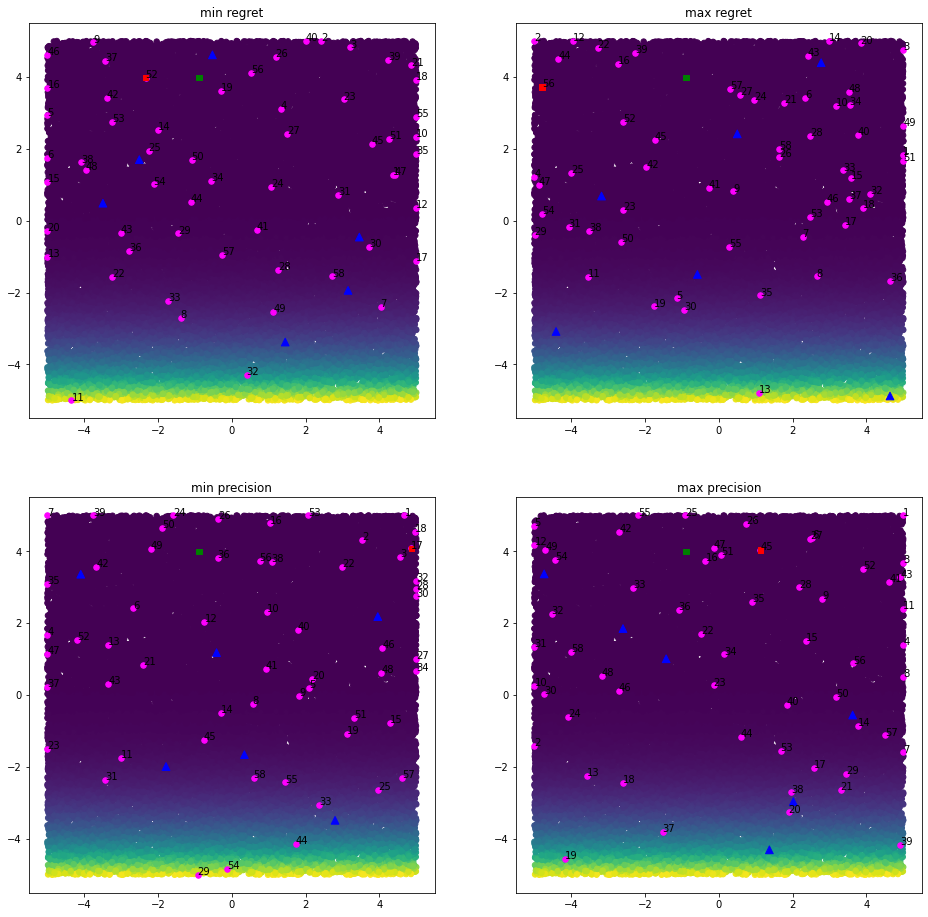

In [14]:
plt.rcParams["figure.figsize"] = (16, 16)
lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision = best_and_worst(lhs_history)
print(f'LHS precision: min={lhs_best_precision["precision"]} max={lhs_worst_precision["precision"]},  LHS regret: min={lhs_best_regret["regret"]}, max={lhs_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (lhs_best_regret, lhs_worst_regret, lhs_best_precision, lhs_worst_precision), marker_size=30)

In [15]:
lhs_best_precision['precision'], lhs_best_precision['regret']

(1.8114849653938884e+20, array([4072.89167519]))

In [16]:
lhs_best_regret['precision'], lhs_best_regret['regret']

(1.818401525342556e+20, array([2.91748633]))

# Uniform

In [17]:
def generate_uniform():
  return np.random.uniform(-5, 5, (doe_size, 2))

In [18]:
uniform_precision, uniform_regret, uniform_history = compute_all_for(generate_uniform, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [19]:
uniform_df = pd.DataFrame(uniform_history).drop(['bo'], axis=1)
uniform_df.to_csv('uniform_doe.csv')

In [20]:
f'Uniform precision: {np.mean(uniform_precision)}, Uniform regret: {np.mean(uniform_regret)}'

'Uniform precision: 1.8179922495281185e+20, Uniform regret: 4652.891060720592'

Uniform precision: min=1.81160857813808e+20 max=1.8258395269900478e+20,  Uniform regret: min=[4.48681576], max=[178107.58186833]


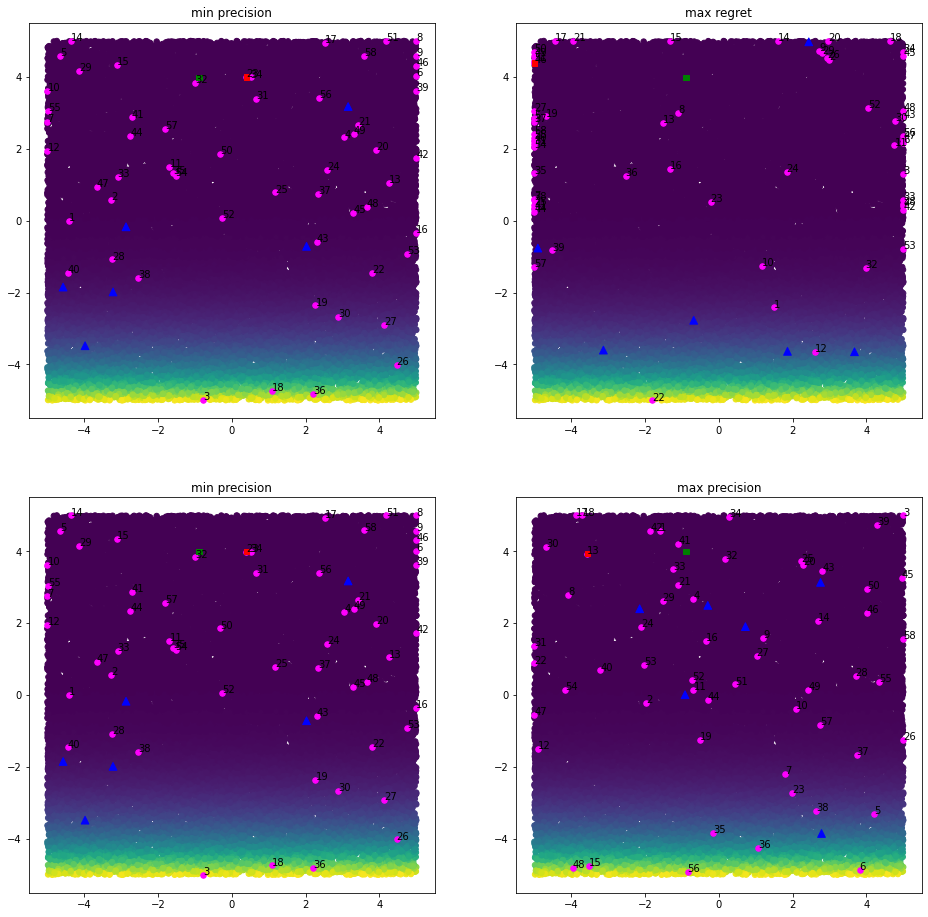

In [21]:
plt.rcParams["figure.figsize"] = (16, 16)
uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision = best_and_worst(uniform_history)
print(f'Uniform precision: min={uniform_best_precision["precision"]} max={uniform_worst_precision["precision"]},  Uniform regret: min={uniform_best_regret["regret"]}, max={uniform_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (uniform_best_regret, uniform_worst_regret, uniform_best_precision, uniform_worst_precision), marker_size=30)

In [22]:
uniform_best_precision['precision'], uniform_best_precision['regret']

(1.81160857813808e+20, array([4.48681576]))

In [23]:
uniform_best_regret['precision'], uniform_best_regret['regret']

(1.81160857813808e+20, array([4.48681576]))

# Sobol

In [24]:
def generate_sobol():
  return Sobol(dim).random(doe_size) * 10 - 5

In [25]:
sobol_precision, sobol_regret, sobol_history = compute_all_for(generate_sobol, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [26]:
sobol_df = pd.DataFrame(sobol_history).drop(['bo'], axis=1)
sobol_df.to_csv('sobol_doe.csv')

In [27]:
f'Sobol precision: {np.mean(sobol_precision)}, Sobol regret: {np.mean(sobol_regret)}'

'Sobol precision: 1.8177593110792123e+20, Sobol regret: 2328.613430396631'

Sobol precision: min=1.8117144010423327e+20 max=1.8215862501165557e+20,  Sobol regret: min=[0.04053392], max=[18944.36140513]


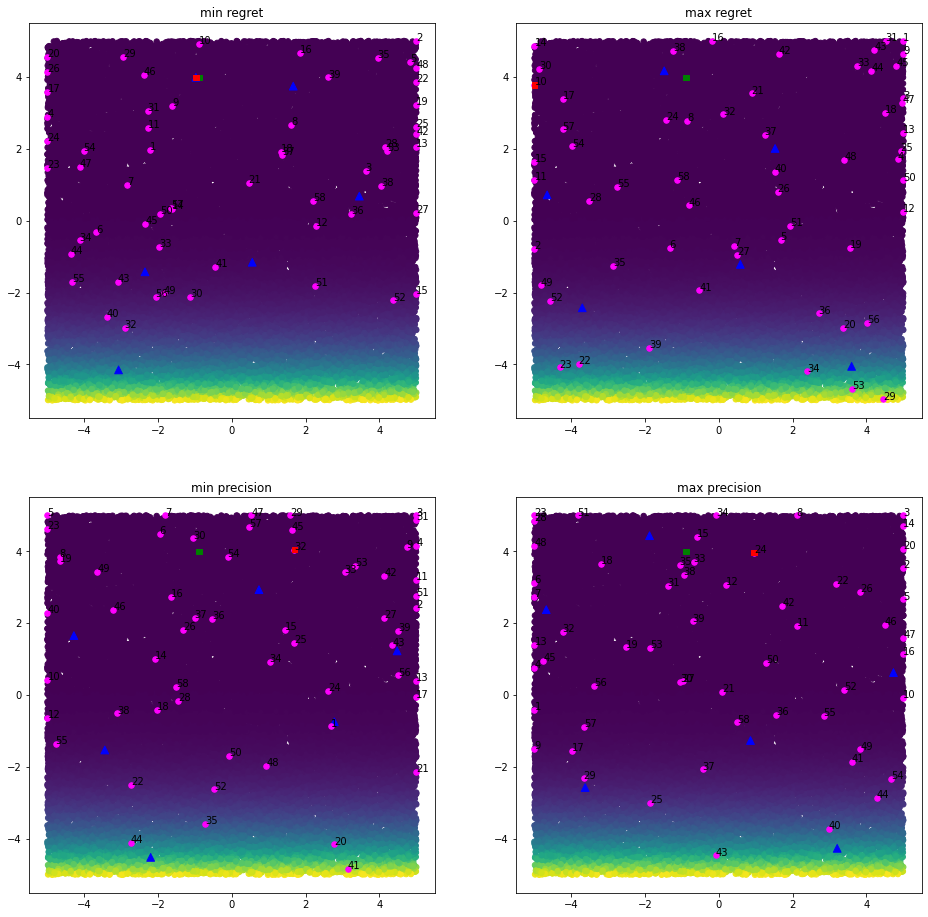

In [28]:
plt.rcParams["figure.figsize"] = (16, 16)
sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision = best_and_worst(sobol_history)
print(f'Sobol precision: min={sobol_best_precision["precision"]} max={sobol_worst_precision["precision"]},  Sobol regret: min={sobol_best_regret["regret"]}, max={sobol_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (sobol_best_regret, sobol_worst_regret, sobol_best_precision, sobol_worst_precision), marker_size=30)

In [29]:
sobol_best_precision['precision'], sobol_best_precision['regret']

(1.8117144010423327e+20, array([1732.26022382]))

In [30]:
sobol_best_regret['precision'], sobol_best_regret['regret']

(1.8178052115472132e+20, array([0.04053392]))

# Halton

In [31]:
def generate_halton():
  return Halton(dim).random(doe_size) * 10 - 5

In [32]:
halton_precision, halton_regret, halton_history = compute_all_for(generate_halton, n=n_runs)

  0%|          | 0/100 [00:00<?, ?it/s]

Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likelihood value. Increasing nugget...
Invalid likel

In [33]:
halton_df = pd.DataFrame(halton_history).drop(['bo'], axis=1)
halton_df.to_csv('halton_doe.csv')

In [34]:
f'Halton precision: {np.mean(halton_precision)}, Halton regret: {np.mean(halton_regret)}'

'Halton precision: 1.818215160042506e+20, Halton regret: 3169.4147342701153'

Halton precision: min=1.8116762669559117e+20 max=1.824848448393066e+20,  Halton regret: min=[6.77190486], max=[28472.31191232]


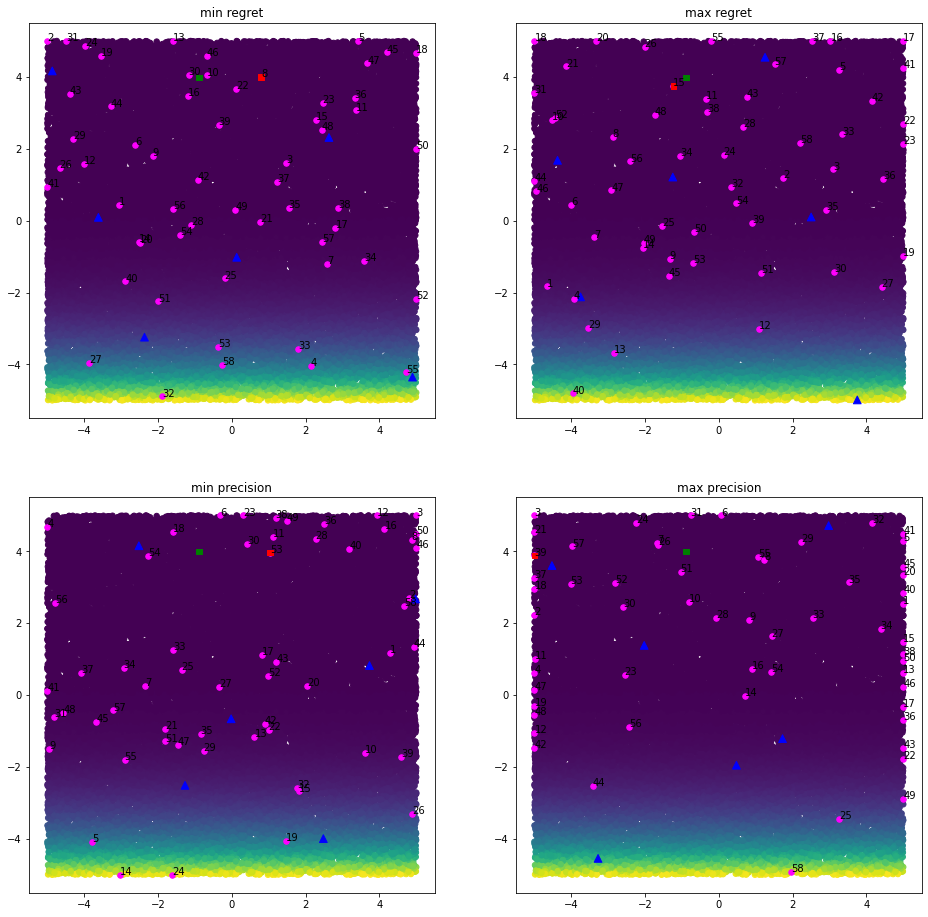

In [35]:
plt.rcParams["figure.figsize"] = (16, 16)
halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision = best_and_worst(halton_history)
print(f'Halton precision: min={halton_best_precision["precision"]} max={halton_worst_precision["precision"]},  Halton regret: min={halton_best_regret["regret"]}, max={halton_worst_regret["regret"]}')
plot_mult_performance(obj_func, samples, values, (halton_best_regret, halton_worst_regret, halton_best_precision, halton_worst_precision), marker_size=30)

In [36]:
halton_best_precision['precision'], halton_best_precision['regret']

(1.8116762669559117e+20, array([808.53627741]))

In [37]:
halton_best_regret['precision'], halton_best_regret['regret']

(1.8185288976708472e+20, array([6.77190486]))

# Compare

In [38]:
all_history = (lhs_history, uniform_history, sobol_history, halton_history)
all_titles = ("lhs", "uniform", "sobol", "halton")

## Regret boxplots

Text(0.5, 1.0, 'Log regret')

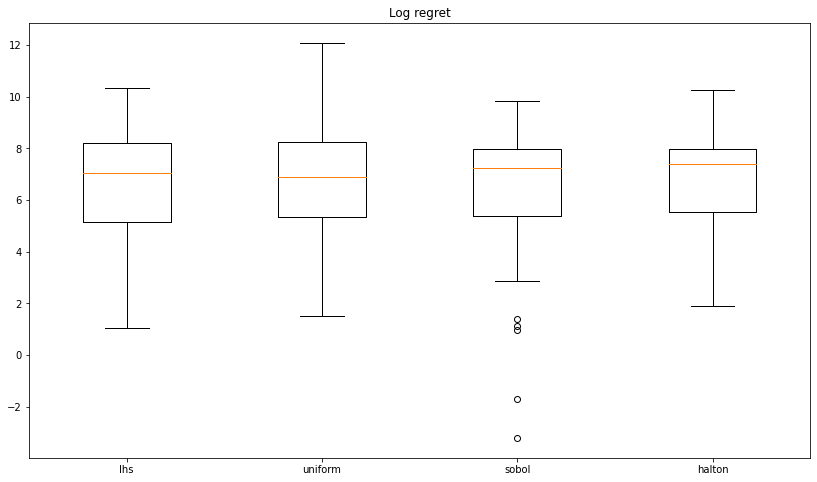

In [44]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [np.log(np.concatenate([result['regret'] for result in history])) for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), all_titles)
plt.title('Log regret')

## Precision boxplots

Text(0.5, 1.0, 'Precision')

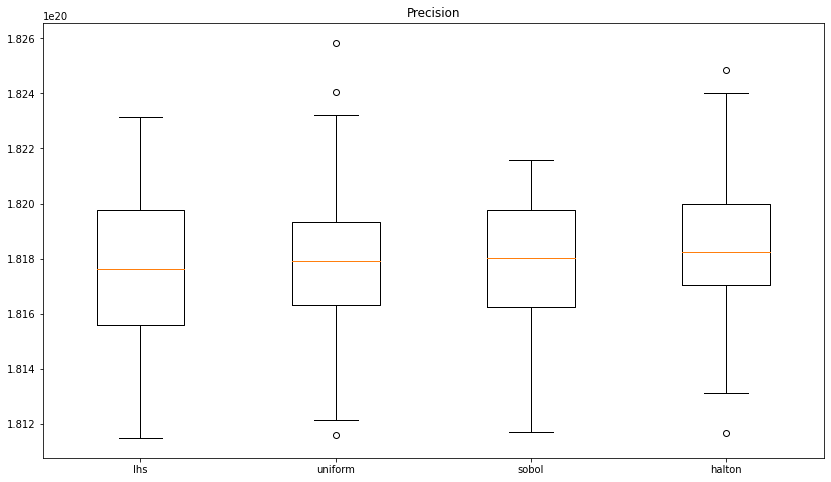

In [45]:
plt.rcParams["figure.figsize"] = (14, 8)
rs = [[result['precision'] for result in history] for history in all_history]
plt.boxplot(rs)
plt.xticks(list(range(1, len(all_history) + 1)), ["lhs", "uniform", "sobol", "halton"])
plt.title('Precision')

## Regret-precision dep

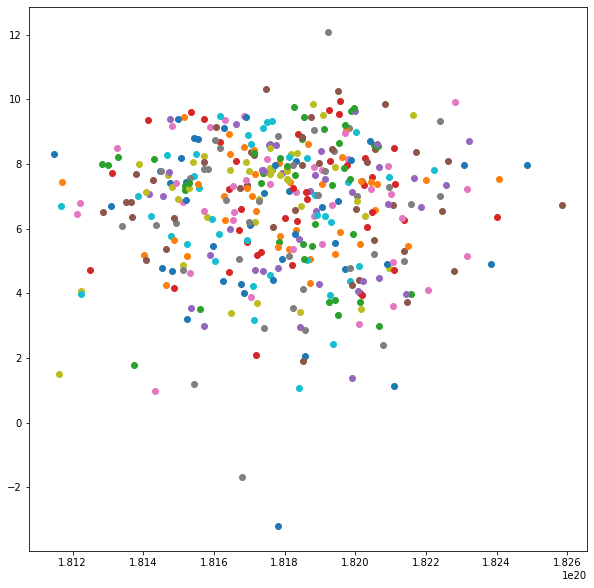

In [48]:
plt.rcParams["figure.figsize"] = (10, 10)
for info in (lhs_history + uniform_history + sobol_history + halton_history):
  plt.scatter(info['precision'], np.log(info['regret']))